In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

#Transformation for image
transform_ori = transforms.Compose([transforms.RandomResizedCrop(64),   #create 64x64 image
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image

In [6]:
#Load our dataset
TRAIN_DATA_PATH = 'C:/Users/Venkat/Desktop/Deep learning - Paul sir/dogvscat/train/'
TEST_DATA_PATH = 'C:/Users/Venkat/Desktop/Deep learning - Paul sir/dogvscat/test/'
train_dataset = datasets.ImageFolder(root = TRAIN_DATA_PATH, transform = transform_ori)

test_dataset = datasets.ImageFolder(root = TEST_DATA_PATH, transform = transform_ori)

In [10]:
#Make the dataset iterable
batch_size = 5
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)      #Shuffle to create a mixed batches of 5 of cat & dog images

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)
print (train_load)
for i, (inputs, labels) in enumerate(train_load):
    print(labels)
    print(inputs.size())
    #print (w,x,y,z)
    
    #print(inputs)

tensor([1, 1, 0, 1, 1])
torch.Size([5, 3, 64, 64])
tensor([1, 0, 1, 1, 0])
torch.Size([5, 3, 64, 64])
tensor([0, 0, 1, 1, 1])
torch.Size([5, 3, 64, 64])
tensor([0, 0, 0, 0, 0])
torch.Size([5, 3, 64, 64])


In [11]:
#Show a batch of images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


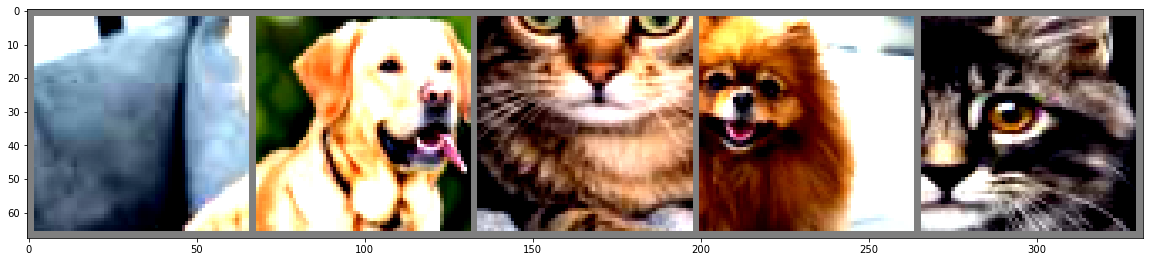

In [12]:
# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16
        
        #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
        self.fc1 = nn.Linear(in_features=8192, out_features=4000)   #Flattened image is fed into linear NN and reduced to half size
        self.droput = nn.Dropout(p=0.5)                    #Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=4000, out_features=2000)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=2000, out_features=500)
        self.droput = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=500, out_features=50)
        self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=50, out_features=2)    #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
       
        
    def forward(self,x):
        #print(x)
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,8192)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc5(out)
        return out

In [14]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [15]:
#Training the CNN 
import time

num_epochs = 50

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        #iter_loss += loss.data[0]       # Accumulate the loss
        iter_loss += loss.data
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        #loss += loss.data[0]
        loss += loss.data
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))


Epoch 1/50, Training Loss: 0.701, Training Accuracy: 55.000, Testing Loss: 0.758, Testing Acc: 50.000, Time: 1.4827675819396973s
Epoch 2/50, Training Loss: 0.698, Training Accuracy: 50.000, Testing Loss: 0.753, Testing Acc: 50.000, Time: 1.4106884002685547s
Epoch 3/50, Training Loss: 0.703, Training Accuracy: 50.000, Testing Loss: 0.752, Testing Acc: 50.000, Time: 1.3884806632995605s
Epoch 4/50, Training Loss: 0.686, Training Accuracy: 55.000, Testing Loss: 0.751, Testing Acc: 50.000, Time: 1.3687539100646973s
Epoch 5/50, Training Loss: 0.701, Training Accuracy: 55.000, Testing Loss: 0.745, Testing Acc: 50.000, Time: 1.3698046207427979s
Epoch 6/50, Training Loss: 0.699, Training Accuracy: 50.000, Testing Loss: 0.733, Testing Acc: 50.000, Time: 1.4379785060882568s
Epoch 7/50, Training Loss: 0.698, Training Accuracy: 40.000, Testing Loss: 0.730, Testing Acc: 50.000, Time: 1.412982702255249s
Epoch 8/50, Training Loss: 0.674, Training Accuracy: 60.000, Testing Loss: 0.722, Testing Acc: 50.

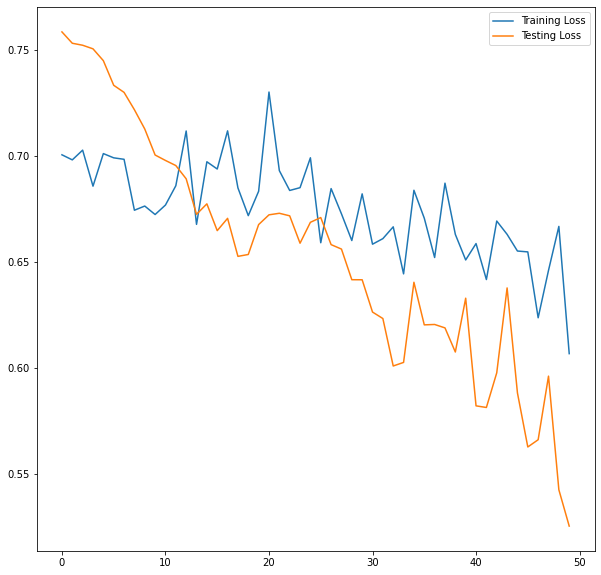

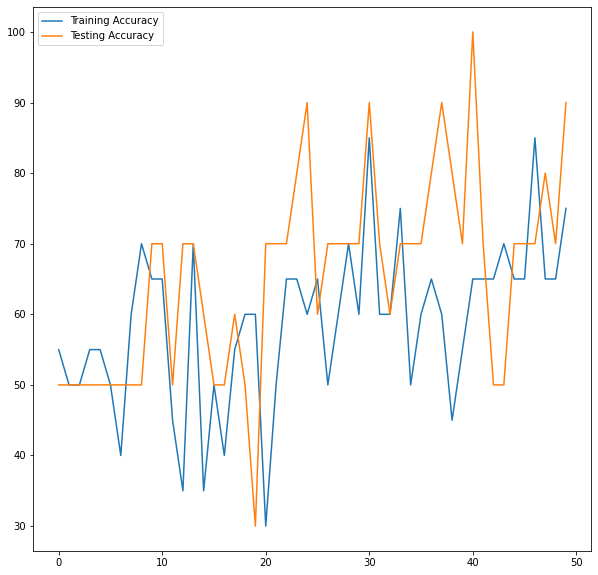

<All keys matched successfully>

In [16]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

#Run this if you want to save the model
torch.save(model.state_dict(),'Cats-Dogs.pth')

#Run this if you want to load the model
model.load_state_dict(torch.load('Cats-Dogs.pth'))